# Ch `13`: Concept `01`

## Continous Bag Of Words

Import the relevant libraries

In [16]:
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

Let's fabricate some data and store as `corpus_raw` lower. 

In [17]:
corpus_raw = """Deep Learning has evolved from Artificial Neural Networks, which has been
there since the 1940s. Neural Networks are interconnected networks of processing units
called artificial neurons that loosely mimic axons in a biological brain. In a biological
neuron, the dendrites receive input signals from various neighboring neurons, typically
greater than 1000. These modified signals are then passed on to the cell body or soma of
the neuron, where these signals are summed together and then passed on to the axon of the
neuron. If the received input signal is more than a specified threshold, the axon will
release a signal which again will pass on to neighboring dendrites of other neurons. Figure
2-1 depicts the structure of a biological neuron for reference. The artificial neuron units
are inspired by the biological neurons with some modifications as per convenience. Much
like the dendrites, the input connections to the neuron carry the attenuated or amplified
input signals from other neighboring neurons. The signals are passed on to the neuron, where
the input signals are summed up and then a decision is taken what to output based on the
total input received. For instance, for a binary threshold neuron an output value of 1 is
provided when the total input exceeds a pre-defined threshold; otherwise, the output stays
at 0. Several other types of neurons are used in artificial neural networks, and their
implementation only differs with respect to the activation function on the total input to
produce the neuron output. In Figure 2-2 the different biological equivalents are tagged in
the artificial neuron for easy analogy and interpretation."""
corpus_raw = corpus_raw.replace('\n', ' ').lower()

Now, let's define our functions.

In [23]:
def one_hot(ind, vocab_size):
    rec = np.zeros(vocab_size)
    rec[ind] = 1
    return rec

def create_training_data(corpus_raw, WINDOW_SIZE = 2):
    words_list = []
    sentences_list = corpus_raw.split('.')    
    for sent in sentences_list:
        for w in sent.split():
            if w != '.':
                words_list.append(w.split('.')[0]) # remove if delimiter is tied to the end of a word
                
    words_list = set(words_list)  # remove the duplicates for each word
    word2ind = {} # converting word to index
    ind2word = {} # retrieving word from index
    vocab_size = len(words_list)
    for i,w in enumerate(words_list):
        word2ind[w] = i
        ind2word[i] = w
    # print the result for testing
    print(word2ind)
    sentences = []
    
    for sent in sentences_list:
        sent_array = sent.split()
        sent_array = [s.split('.')[0] for s in sent_array]
        sentences.append(sent_array)
        
    data_recs = []
    
    for sent in sentences:
        for ind,w in enumerate(sent):
            rec = []
            for nb_w in sent[max(ind - WINDOW_SIZE, 0) : min(ind + WINDOW_SIZE, len(sent)) + 1]:
                if nb_w != w:
                    rec.append(nb_w)
                data_recs.append([rec, w])
    x_train,y_train = [],[]
    
    for rec in data_recs:
        input_ = np.zeros(vocab_size)
        for i in range(WINDOW_SIZE - 1):
            input_ += one_hot(word2ind[rec[0][i]], vocab_size)
        input_ = input_ / len(rec[0])
        x_train.append(input_)
        y_train.append(one_hot(word2ind[rec[1]], vocab_size))
    
    return x_train, y_train, word2ind, ind2word, vocab_size

When defining the model, let's train it.

{'neural': 0, 'with': 1, 'neighboring': 2, 'than': 3, 'taken': 4, 'pass': 5, 'types': 6, 'threshold;': 7, 'analogy': 8, 'depicts': 9, 'again': 10, 'dendrites': 11, 'there': 12, 'output': 13, 'only': 14, 'body': 15, 'deep': 16, 'instance,': 17, 'that': 18, 'soma': 19, 'on': 20, 'or': 21, 'evolved': 22, 'learning': 23, 'been': 24, 'implementation': 25, 'these': 26, 'greater': 27, 'inspired': 28, 'function': 29, 'receive': 30, 'provided': 31, 'and': 32, '1': 33, 'used': 34, 'a': 35, 'of': 36, 'together': 37, 'artificial': 38, 'interconnected': 39, 'in': 40, 'to': 41, 'some': 42, 'neuron,': 43, 'dendrites,': 44, 'then': 45, 'passed': 46, 'decision': 47, 'an': 48, 'called': 49, 'are': 50, 'is': 51, 'the': 52, 'total': 53, 'stays': 54, 'where': 55, 'other': 56, 'since': 57, 'neurons,': 58, '1000': 59, 'will': 60, 'mimic': 61, 'processing': 62, 'more': 63, 'differs': 64, 'pre-defined': 65, 'up': 66, 'typically': 67, 'when': 68, 'axon': 69, 'biological': 70, 'easy': 71, 'per': 72, 'connections

(-150, 150)

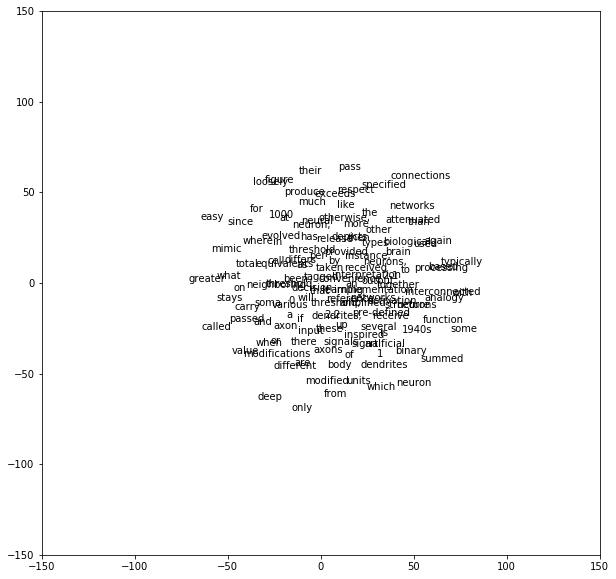

In [24]:
x_train, y_train, word2ind, ind2word, vocab_size = create_training_data(corpus_raw, 2)
emb_dims = 128
learning_rate = 0.001

# placeholders for input and output
x = tf.placeholder(tf.float32, [None, vocab_size])
y = tf.placeholder(tf.float32, [None, vocab_size])

# define embedding matrix weights and a bias
W = tf.Variable(tf.random_normal([vocab_size, emb_dims], mean=0.0, stddev=0.02, dtype=tf.float32))
b = tf.Variable(tf.random_normal([emb_dims], mean=0.0, stddev=0.02, dtype=tf.float32))
W_outer = tf.Variable(tf.random_normal([emb_dims, vocab_size], mean=0.0, stddev=0.02, dtype=tf.float32))
b_outer = tf.Variable(tf.random_normal([vocab_size], mean=0.0, stddev=0.02, dtype=tf.float32))

hidden = tf.add(tf.matmul(x, W),b)
logits = tf.add(tf.matmul(hidden, W_outer), b_outer)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

epochs, batch_size = 100, 10
batch = len(x_train) # batch_size

# train for n iterations
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        batch_index = 0
        for batch_num in range(batch):
            x_batch = x_train[batch_index: batch_index + batch_size]
            y_batch = y_train[batch_index: batch_index + batch_size]
            sess.run(optimizer, feed_dict={x:x_batch, y:y_batch})
#         if epoch % 10 == 0:
        print('epoch:', epoch, 'loss:', sess.run(cost, feed_dict={x:x_batch, y:y_batch}))
    
    W_embed_trained = sess.run(W)
    
W_embedded = TSNE(n_components=2).fit_transform(W_embed_trained)
plt.figure(figsize=(10,10))
for i in range(len(W_embedded)):
    plt.text(W_embedded[i,0], W_embedded[i,1], ind2word[i])
    
    
plt.xlim(-150, 150)
plt.ylim(-150, 150)
